# Algoritmo do Bandido

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="k-armed_bandit.png" width="400">

Você deve repetidamente escolher uma entre $k$ diferentes ações. Após cada escolha, você recebe uma recompensa numérica (distribuição probabilística) ligada a sua ação e que pode influenciar suas escolhas futuras. Seu objetivo é maximizar a recompensa total esperada ao final de um período fazendo as escolhas certas.

Importando bibliotecas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,4)

Criando e inicializando a classe do Bandido.

In [2]:
class Bandit:
    ##########################################
    def __init__(self, parameters):

        # k bandits
        self.K = parameters['k-armed']
        
        # testbed
        self.testbed = [{'mean': 2.0*np.random.uniform(-1.0,1.0), 'std': 0.5} for a in range(self.K)]
        
        # numero de jogadas de 1 episodio
        self.steps = parameters['steps']
        
        # epsilon-greedy
        self.eps = parameters['eps']
        
        # constant c do UCB
        self.c = parameters['c']

        # initialize action values
        self.Q = np.array([parameters['opt_init'] for a in range(self.K)])
        self.N = np.array([0.0 for a in range(self.K)])

        # metodo
        self.method = parameters['method']
        
        # instante de tempo
        self.t = 0
        
        # melhor acao dentre todas
        self.best_action = np.argmax([t['mean'] for t in self.testbed])

    ##########################################
    # bandit
    def bandit(self, A):
        return np.random.normal(self.testbed[A]['mean'], self.testbed[A]['std'])

A função de classe ```selectAction()``` implementa duas versões de escolha da ação, a quase-gulosa (ou $\varepsilon$-gulosa),
 
$$
A_t = 
\begin{cases}
    \arg\!\max\limits_{a} ~Q_t(a) & \text{com probabilidade}~ 1 - \varepsilon,\\
    \textrm{ação aleatória} & \text{com probabilidade}~ \varepsilon
\end{cases}
$$

e a Upper-Confidence-Bound (UCB),

$$
A_t \doteq \arg\!\max_{a} \left[ Q_t(a) + c~ \sqrt{\frac{\ln t}{N_t(a)}}~\right].
$$

In [3]:
class Bandit(Bandit):
    ##########################################
    def selectAction(self):
        #################################
        if self.method == 'e-greedy':
            # exploration
            if np.random.random() <= self.eps:
                a = np.random.choice(self.K)
            # explotation
            else:
                a = np.argmax(self.Q)

        #################################
        if self.method == 'ucb':
            ucb = np.array([self.c*np.sqrt(np.log(self.t)/(self.N[A]+0.1)) for A in range(self.K)])
            a = np.argmax(self.Q + ucb)
            
        return a

Função da classe que executa um episódio.

In [4]:
class Bandit(Bandit):
    ##########################################
    def runEpisode(self):
        rewards = []     # rewards de um epsodio
        best_action = [] # escolha da melhor acao

        # main loop
        for _ in range(self.steps):
            self.t += 1
            
            # select action
            A = self.selectAction()

            # get reward
            R = self.bandit(A)

            # update action-value
            self.N[A] = self.N[A] + 1
            self.Q[A] = self.Q[A] + (1.0/self.N[A])*(R - self.Q[A])

            rewards.append(R) # accumulate rewards
            best_action.append(A == self.best_action) # acumula melhor acao

        return rewards, best_action

Aqui, com os parâmetros fornecidos, rodamos vários episódios do problema, retornando o comportamento médio destes.

In [5]:
def main(parameters):
    accum_reward = []
    accum_action = []
    
    for _ in range(parameters['episodes']):
        
        # cria o testbed
        bandit = Bandit(parameters)
        
        # roda um epsodio
        rewards, best_action = bandit.runEpisode()
        accum_reward.append(rewards)
        accum_action.append(best_action)

    # media de todos os epsodios
    avg_reward = np.mean(accum_reward, 0)

    # acao otima
    opt_action = 100.0*np.mean(accum_action, 0)
    
    return avg_reward, opt_action

Definindo parâmetros principais do algoritmo:
- k-armed: número de braços
- steps: passos do episódio
- episodes: número de episódios
- method: $\varepsilon$-*greedy* ou UCB
- eps: $\varepsilon$
- c: ganho do UCB
- opt_init: inicialização otimísta -> Q(a) = opt_init

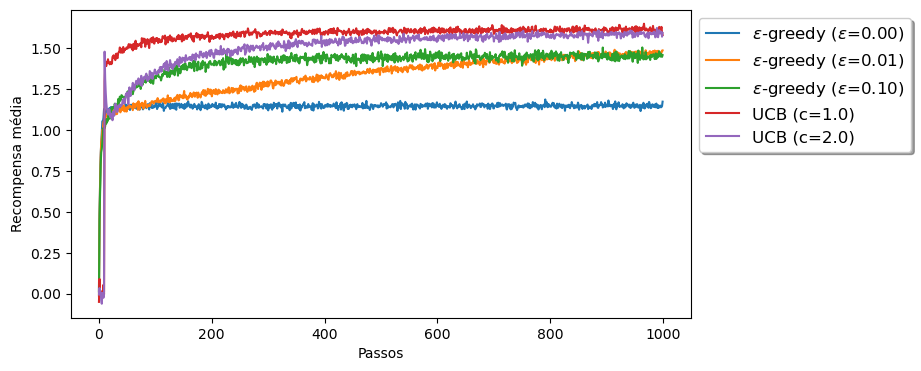

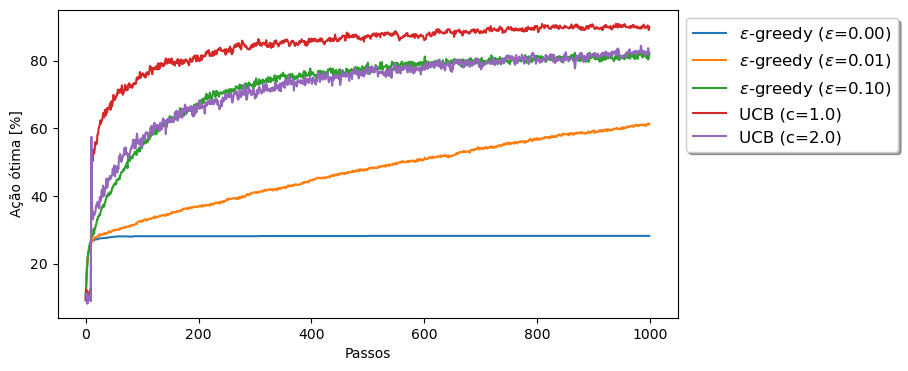

In [6]:
if __name__ == "__main__":
   
    # parametros
    parameters = {
                'k-armed'  : 10,
                'steps'    : 1000,
                'episodes' : 2000,
                'method'   : '', # 'e-greedy' ou 'ucb'
                'eps'      : 0.0,
                'c'        : 1.0,
                'opt_init' : 0.0, # Q(a) = 0 -> Q(a) = +5.0, eventualmente performa melhor (exploracao cai com o tempo)
            }
    
    ##########################################
    # greedy and nongreedy
    parameters['method'] = 'e-greedy'
    for eps in [0.0, 0.01, 0.1]:
        parameters['eps'] = eps
        avg_reward, opt_action = main(parameters)
        
        plt.figure(1)
        plt.plot(avg_reward, label=f"$\\epsilon$-greedy ($\\epsilon$={eps:.2f})")
        plt.figure(2)
        plt.plot(opt_action, label=f"$\\epsilon$-greedy ($\\epsilon$={eps:.2f})")
    
    ##########################################
    # Upper-Confidence-Bound
    parameters['method'] = 'ucb'
    for c in [1.0, 2.0]:
        parameters['c'] = c
        avg_reward, opt_action = main(parameters)

        plt.figure(1)
        plt.plot(avg_reward, label=f"UCB (c={c:.1f})")
        plt.figure(2)
        plt.plot(opt_action, label=f"UCB (c={c:.1f})")
    
    ##########################################
    plt.figure(1)
    plt.xlabel('Passos')
    plt.ylabel('Recompensa média')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, fontsize=12, facecolor='w')

    plt.figure(2)
    plt.xlabel('Passos')
    plt.ylabel('Ação ótima [%]')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, fontsize=12, facecolor='w')

    plt.show()